In [1]:
import os
import gc
import time
import psutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Union
from tqdm.notebook import tqdm
from datetime import datetime, timedelta
from sklearn.model_selection import GroupKFold
from sklearn.utils import shuffle
from multiprocessing import Pool
import lightgbm as lgb
from tqdm.notebook import tqdm
pd.set_option('display.max_columns', None)
try:
    print('available GPU devices:', len(os.environ['CUDA_VISIBLE_DEVICES']), 
          ' | device num:', os.environ['CUDA_VISIBLE_DEVICES'])
except:
    print('no environ cuda device variables')

no environ cuda device variables


In [2]:
SEED = 80
DATA_DIR = 'C:/data/m5/data_upd'
MODELS_DIR = 'C:/data/m5/models'
MODEL_VER = 'v0'
CUT_DATE = '2011-01-01'
END_D = 1941
PRED_FWD = 28
SHIFT_LCL = 28
N_CORES = int(psutil.cpu_count() * .75)
N_FOLDS = 4
print('num pf cores:', N_CORES)
#---|CUT_DATE|---train---|END_D - PRED_FWD|--val--|END_D|--forecast-->|END_D + PRED_FWD|

num pf cores: 9


### LOAD AND PREPROCESS

In [3]:
CALENDAR_DTYPES = {
    'date':             'str',
    'wm_yr_wk':         'int16', 
    'weekday':          'object',
    'wday':             'int8', 
    'month':            'int8', 
    'year':             'int16', 
    'd':                'object',
    'event_name_1':     'object',
    'event_type_1':     'object',
    'event_name_2':     'object',
    'event_type_2':     'object',
    'snap_CA':          'int8', 
    'snap_TX':          'int8', 
    'snap_WI':          'int8'
}
PARSE_DATES = ['date']
SPRICES_DTYPES = {
    'store_id':    'object', 
    'item_id':     'object', 
    'wm_yr_wk':    'int16',  
    'sell_price':  'float16'
}
DROP_COLS = ['id', 'sales', 'date', 'wm_yr_wk', 'weekday', 'wday']
CAT_COLS = [
    'item_id', 'dept_id', 'store_id', 'cat_id', 'state_id', 
    'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
    'snap_CA', 'snap_TX', 'snap_WI'
]

In [4]:
def get_df():
    start_time = time.time()
    print('-' * 10, 'BASE GRID', '-' * 10)
    strain = pd.read_csv('{}/sales_train_evaluation.csv'.format(DATA_DIR))
    print('read train:', strain.shape)
    for day in range(END_D + 1, END_D + PRED_FWD + 1):
        strain['d_{}'.format(day)] = np.nan
    strain = pd.melt(
        strain,
        id_vars = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id'],
        value_vars = [col for col in strain.columns if col.startswith('d_')],
        var_name = 'd',
        value_name = 'sales'
    )
    print('melted train:', strain.shape)
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    calendar = pd.read_csv('{}/calendar.csv'.format(DATA_DIR), dtype=CALENDAR_DTYPES, parse_dates=PARSE_DATES)
    print('read calendar:', calendar.shape)
    strain = strain.merge(calendar, on='d', copy=False)
    strain.drop(columns=['month', 'year'], inplace=True)
    strain['d'] = strain['d'].apply(lambda x: int(x.replace('d_', '')))  
    print('calendar merge done:', strain.shape)
    strain['tm_d'] = strain['date'].dt.day.astype(np.int8)
    strain['tm_w'] = strain['date'].dt.week.astype(np.int8)
    strain['tm_m'] = strain['date'].dt.month.astype(np.int8)
    strain['tm_y'] = strain['date'].dt.year
    strain['tm_y'] = (strain['tm_y'] - strain['tm_y'].min()).astype(np.int8)
    strain['tm_wm'] = strain['tm_d'].apply(lambda x: np.ceil(x / 7)).astype(np.int8)
    strain['tm_dw'] = strain['date'].dt.dayofweek.astype(np.int8)
    strain['tm_w_end'] = (strain['tm_dw'] >= 5).astype(np.int8)
    print('date features done')
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    sprices = pd.read_csv('{}/sell_prices.csv'.format(DATA_DIR), dtype=SPRICES_DTYPES)
    print('read prices:', sprices.shape)
    release_df = sprices.groupby(['store_id', 'item_id'])['wm_yr_wk'].agg(['min']).reset_index()
    release_df.columns = ['store_id', 'item_id', 'release']
    strain = strain.merge(release_df, on=['store_id', 'item_id'], how='left')
    del release_df
    print('release feature done')
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    sprices['price_max'] = sprices.groupby(['store_id', 'item_id'])['sell_price'].transform('max')
    sprices['price_min'] = sprices.groupby(['store_id', 'item_id'])['sell_price'].transform('min')
    sprices['price_std'] = sprices.groupby(['store_id', 'item_id'])['sell_price'].transform('std')
    sprices['price_mean'] = sprices.groupby(['store_id', 'item_id'])['sell_price'].transform('mean')
    sprices['price_norm'] = sprices['sell_price'] / sprices['price_max']
    sprices['price_nunique'] = sprices.groupby(['store_id', 'item_id'])['sell_price'].transform('nunique')
    sprices['item_nunique'] = sprices.groupby(['store_id', 'sell_price'])['item_id'].transform('nunique')
    calendar_prices = calendar[['wm_yr_wk', 'month', 'year']]
    calendar_prices = calendar_prices.drop_duplicates(subset=['wm_yr_wk'])
    sprices = sprices.merge(calendar_prices[['wm_yr_wk', 'month', 'year']], on=['wm_yr_wk'], how='left')
    del calendar, calendar_prices
    sprices['price_momentum'] = sprices['sell_price'] / sprices.groupby(
        ['store_id', 'item_id']
    )['sell_price'].transform(lambda x: x.shift(1))
    sprices['price_variance_w'] = sprices['sell_price'] / sprices.groupby(
        ['store_id', 'item_id', 'wm_yr_wk']
    )['sell_price'].transform('std')
    sprices['price_momentum_m'] = sprices['sell_price'] / sprices.groupby(
        ['store_id', 'item_id', 'month']
    )['sell_price'].transform('mean')
    sprices['price_variance_m'] = sprices['sell_price'] / sprices.groupby(
        ['store_id', 'item_id', 'month']
    )['sell_price'].transform('std')
    sprices['price_momentum_y'] = sprices['sell_price'] / sprices.groupby(
        ['store_id', 'item_id', 'year']
    )['sell_price'].transform('mean')
    sprices['price_variance_y'] = sprices['sell_price'] / sprices.groupby(
        ['store_id', 'item_id', 'year']
    )['sell_price'].transform('std')
    strain = strain.merge(sprices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')
    strain.drop(columns=['month', 'year'], inplace=True)
    del sprices
    print('prices features and merge done:', strain.shape)
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    for col in CAT_COLS:
        strain[col]= strain[col].astype('category')
        strain[col] = strain[col].cat.codes.astype('int16')
        strain[col] -= strain[col].min()
    print('cols to category done:', strain.shape)
    print('begin train date:', strain['date'].min())
    print('end train date:', strain['date'].max())
    strain = strain.loc[strain['date'] >= CUT_DATE]
    print('date cut train:', strain.shape)
    print('cut train date:', strain['date'].min())
    print('end train date:', strain['date'].max())
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    gc.collect()
    return strain

In [5]:
def make_features_adv(strain):
    start_time = time.time()
    print('-' * 10, 'ADVANCED FEATURES', '-' * 10)
    print('in dataframe:', strain.shape)
    icols =  [
        ['state_id'],
        ['store_id'],
        ['cat_id'],
        ['dept_id'],
        ['state_id', 'cat_id'],
        ['state_id', 'dept_id'],
        ['store_id', 'cat_id'],
        ['store_id', 'dept_id'],
        ['item_id'],
        ['item_id', 'state_id'],
        ['item_id', 'store_id']
    ]
    cols = list(set([item for sublist in icols for item in sublist]))
    cols.extend(['d', 'sales'])
    df_temp = strain[cols].copy()
    df_temp.loc[df_temp['d'] > (END_D - PRED_FWD), 'sales'] = np.nan
    for col in icols:
        col_name = '_{}_'.format('_'.join(col))
        strain['enc{}mean'.format(col_name)] = df_temp.groupby(col)['sales'].transform('mean').astype(np.float16)
        strain['enc{}std'.format(col_name)] = df_temp.groupby(col)['sales'].transform('std').astype(np.float16)
    print('encoding done')
    del df_temp
    gc.collect()
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    return strain

In [6]:
def make_features_lag(strain):
    start_time = time.time()
    print('-' * 10, 'LAG AND ROLL FEATURES', '-' * 10)
    print('in dataframe:', strain.shape)
    lags = range(PRED_FWD, PRED_FWD + 14 + 1)
    lag_cols = ['lag_{}'.format(lag) for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        strain[lag_col] = strain[['id', 'sales']].groupby(['id'])['sales'].shift(lag).astype(np.float16)
    print('lag sales done')
    for roll in [7, 14, 30, 60, 180]:
        roll_col = 'lag_{}_roll_mean_{}'.format(PRED_FWD, roll)
        strain[roll_col] = strain[['id', 'sales']].groupby(['id'])['sales'].transform(
            lambda x: x.shift(PRED_FWD).rolling(roll).mean()
        ).astype(np.float16)
        roll_col = 'lag_{}_roll_std_{}'.format(PRED_FWD, roll)
        strain[roll_col] = strain[['id', 'sales']].groupby(['id'])['sales'].transform(
            lambda x: x.shift(PRED_FWD).rolling(roll).std()
        ).astype(np.float16)
    print('roll mean and std sales done')
    print('out dataframe:', strain.shape)
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    return strain

In [7]:
def make_features_last_sales(strain):
    start_time = time.time()
    print('-' * 10, 'LAST SALES FEATURE', '-' * 10)
    print('in dataframe:', strain.shape)
    n_day = 1    
    last_sales = strain[['id', 'd', 'sales']].copy()
    last_sales['non_zero'] = (last_sales['sales'] > 0).astype(np.int8)
    last_sales['non_zero_lag'] = last_sales.groupby(['id'])['non_zero'].transform(
        lambda x: x.shift(n_day).rolling(2000, 1).sum()
    ).fillna(-1)
    df_temp = last_sales[['id', 'd', 'non_zero_lag']].drop_duplicates(subset=['id', 'non_zero_lag'])
    df_temp.columns = ['id', 'd_min', 'non_zero_lag']
    last_sales = last_sales.merge(df_temp, on=['id', 'non_zero_lag'], how='left')
    strain.loc[:, 'last_sale'] = (last_sales['d'] - last_sales['d_min']).astype(np.int16)
    del last_sales, df_temp
    gc.collect()
    print('last non zero sales done')
    print('out dataframe:', strain.shape)
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    return strain

In [8]:
def make_features_win(strain):
    start_time = time.time()
    print('-' * 10, 'WIN ROLL FEATURES', '-' * 10)
    print('in dataframe:', strain.shape)
    lags = [1, 7, 14, 30]
    windows= [7, 14, 30, 60]
    for lag in lags:
        for wnd in windows:
            wnd_col = 'lag_{}_roll_mean_{}'.format(lag, wnd)
            strain[wnd_col] = strain[['id', 'sales']].groupby(['id'])['sales'].transform(
                lambda x: x.shift(lag).rolling(wnd).mean().astype(np.float16)
            )
    print('window roll mean sales done')
    print('out dataframe:', strain.shape)
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    return strain

In [9]:
%%time
LOAD_DATA = True
if not LOAD_DATA:
    strain = get_df()
    strain = make_features_adv(strain)
    strain = make_features_lag(strain)
    strain = make_features_last_sales(strain)
    strain = make_features_win(strain)
    file_name = '{}/strain.pkl'.format(DATA_DIR)
    strain.to_pickle(file_name)
    print('saved to file:', file_name)
else:
    strain = pd.read_pickle('{}/strain.pkl'.format(DATA_DIR))
    print('loaded:', strain.shape)

loaded: (60034810, 105)
Wall time: 23.9 s


from 2011-01-29 00:00:00 to 2016-06-19 00:00:00


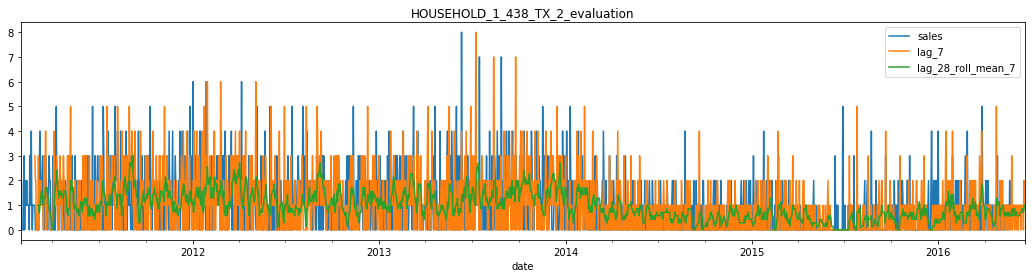

In [10]:
id_name = np.random.choice(strain['id'].unique())
id_sales = strain.loc[strain['id'] == id_name].set_index('date')
print('from', strain['date'].min(), 'to', strain['date'].max()) 
plt.figure(figsize=(18, 4))
id_sales['sales'].plot(label='sales')
id_sales['lag_28'].plot(label='lag_7')
id_sales['lag_28_roll_mean_7'].plot(label='lag_28_roll_mean_7')
plt.title(id_name)
plt.legend()
plt.show()

In [11]:
train_cols = strain.columns[~strain.columns.isin(DROP_COLS)]
store_ids = list(strain['store_id'].unique())
print('stores:', store_ids)

stores: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


### TRAINING

In [12]:
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'tweedie',
    'tweedie_variance_power': 1.1,
    'metric': 'rmse',
    'subsample': .5,
    'subsample_freq': 1,
    'learning_rate': .03,
    'num_leaves': 2 ** 11 - 1,
    'min_data_in_leaf': 2 ** 12 - 1,
    'feature_fraction': .5,
    'max_bin': 100,
    'n_estimators': 2000,
    'boost_from_average': False,
    'verbose': 1,
    'nthread': N_CORES,
    'early_stopping_rounds': 50,
    'lambda_l2': .1,
    'seed': SEED
}

In [13]:
for store_id in tqdm(store_ids):
    print('=' * 10, 'store training:', store_id, '=' * 10)
    strain_id = strain[(strain['d'] <= (END_D - SHIFT_LCL)) & (strain['store_id'] == store_id)].copy()
    strain_id['groups'] = strain_id['tm_w'].astype(str) + '_' + strain_id['tm_y'].astype(str)
    split_groups = strain_id['groups']
    folds = GroupKFold(n_splits=N_FOLDS)
    for fold_num, (trn_ids, val_ids) in enumerate(folds.split(strain_id, groups=split_groups)):
        print('-' * 10, 'fold training:', fold_num, '-' * 10)
        X_train = strain_id[train_cols].iloc[trn_ids]
        y_train = strain_id['sales'].iloc[trn_ids]
        X_val = strain_id[train_cols].iloc[val_ids]
        y_val = strain_id['sales'].iloc[val_ids]
        print('train shapes:', X_train.shape, len(y_train))
        print('val shapes:', X_val.shape, len(y_val))
        train_lgb = lgb.Dataset(X_train, label=y_train, categorical_feature=CAT_COLS, free_raw_data=False)
        val_lgb = lgb.Dataset(X_val, label=y_val, categorical_feature=CAT_COLS, free_raw_data=False)
        del X_train, y_train, X_val, y_val
        gc.collect()
        model = lgb.train(lgb_params, train_lgb, valid_sets=[val_lgb], verbose_eval=200) 
        model_file = '{}/model_{}_store_{}_fold_{}.lgb'.format(MODELS_DIR, MODEL_VER, store_id, fold_num)
        model.save_model(model_file)
        print('save to file:', model_file)
    del strain_id, train_lgb, val_lgb
    gc.collect()

========== store training: 0 ==========
---------- fold training: 0 ----------
train shapes: (4436295, 99) 4436295
val shapes: (1481814, 99) 1481814


C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 2.17527
[400]	valid_0's rmse: 2.13368
[600]	valid_0's rmse: 2.12036
Early stopping, best iteration is:
[626]	valid_0's rmse: 2.1197
save to file: C:/data/m5/models/model_v0_store_0_fold_0.lgb
---------- fold training: 1 ----------
train shapes: (4442393, 99) 4442393
val shapes: (1475716, 99) 1475716
Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 2.23904
[400]	valid_0's rmse: 2.20768
Early stopping, best iteration is:
[492]	valid_0's rmse: 2.2038
save to file: C:/data/m5/models/model_v0_store_0_fold_1.lgb
---------- fold training: 2 ----------
train shapes: (4436295, 99) 4436295
val shapes: (1481814, 99) 1481814
Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 2.28608
[400]	valid_0's rmse: 2.2465
[600]	valid_0's rmse: 2.23343
[800]	valid_0's rmse: 2.22696
[1000]	valid_0's rmse: 2.22386
Early stopping, best iteration is:
[1035]	valid_0's

C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 1.76987
[400]	valid_0's rmse: 1.75434
[600]	valid_0's rmse: 1.74905
[800]	valid_0's rmse: 1.74597
[1000]	valid_0's rmse: 1.74456
[1200]	valid_0's rmse: 1.74333
[1400]	valid_0's rmse: 1.74261
Early stopping, best iteration is:
[1467]	valid_0's rmse: 1.74237
save to file: C:/data/m5/models/model_v0_store_1_fold_0.lgb
---------- fold training: 1 ----------
train shapes: (4442393, 99) 4442393
val shapes: (1475716, 99) 1475716
Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 1.70861
[400]	valid_0's rmse: 1.70036
Early stopping, best iteration is:
[523]	valid_0's rmse: 1.69942
save to file: C:/data/m5/models/model_v0_store_1_fold_1.lgb
---------- fold training: 2 ----------
train shapes: (4436295, 99) 4436295
val shapes: (1481814, 99) 1481814
Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 1.69426
[400]	valid_0's rmse: 1.68456
[600]	valid_0's

C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 3.03702
[400]	valid_0's rmse: 2.95681
[600]	valid_0's rmse: 2.93411
[800]	valid_0's rmse: 2.92757
Early stopping, best iteration is:
[827]	valid_0's rmse: 2.9271
save to file: C:/data/m5/models/model_v0_store_2_fold_0.lgb
---------- fold training: 1 ----------
train shapes: (4442393, 99) 4442393
val shapes: (1475716, 99) 1475716
Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 3.09297
[400]	valid_0's rmse: 3.03147
Early stopping, best iteration is:
[490]	valid_0's rmse: 3.02824
save to file: C:/data/m5/models/model_v0_store_2_fold_1.lgb
---------- fold training: 2 ----------
train shapes: (4436295, 99) 4436295
val shapes: (1481814, 99) 1481814
Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 3.26086
[400]	valid_0's rmse: 3.1258
[600]	valid_0's rmse: 3.10015
Early stopping, best iteration is:
[715]	valid_0's rmse: 3.09227
save to file: C:

C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 1.31401
[400]	valid_0's rmse: 1.30241
[600]	valid_0's rmse: 1.29882
[800]	valid_0's rmse: 1.29728
[1000]	valid_0's rmse: 1.29634
[1200]	valid_0's rmse: 1.29585
Early stopping, best iteration is:
[1237]	valid_0's rmse: 1.29576
save to file: C:/data/m5/models/model_v0_store_3_fold_0.lgb
---------- fold training: 1 ----------
train shapes: (4442393, 99) 4442393
val shapes: (1475716, 99) 1475716
Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 1.34618
[400]	valid_0's rmse: 1.33749
[600]	valid_0's rmse: 1.33392
[800]	valid_0's rmse: 1.33224
[1000]	valid_0's rmse: 1.33174
Early stopping, best iteration is:
[959]	valid_0's rmse: 1.33169
save to file: C:/data/m5/models/model_v0_store_3_fold_1.lgb
---------- fold training: 2 ----------
train shapes: (4436295, 99) 4436295
val shapes: (1481814, 99) 1481814
Training until validation scores don't improve for 50 rounds
[200]	valid_0's

C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 1.85975
[400]	valid_0's rmse: 1.83281
Early stopping, best iteration is:
[547]	valid_0's rmse: 1.82738
save to file: C:/data/m5/models/model_v0_store_4_fold_0.lgb
---------- fold training: 1 ----------
train shapes: (4442393, 99) 4442393
val shapes: (1475716, 99) 1475716
Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 1.83389
[400]	valid_0's rmse: 1.80508
[600]	valid_0's rmse: 1.79532
[800]	valid_0's rmse: 1.7926
[1000]	valid_0's rmse: 1.78845
[1200]	valid_0's rmse: 1.78617
[1400]	valid_0's rmse: 1.78515
[1600]	valid_0's rmse: 1.78341
[1800]	valid_0's rmse: 1.78257
Early stopping, best iteration is:
[1819]	valid_0's rmse: 1.78218
save to file: C:/data/m5/models/model_v0_store_4_fold_1.lgb
---------- fold training: 2 ----------
train shapes: (4436295, 99) 4436295
val shapes: (1481814, 99) 1481814
Training until validation scores don't improve for 50 rounds
[200]	valid_0'

C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 2.26945
[400]	valid_0's rmse: 2.22852
[600]	valid_0's rmse: 2.21451
[800]	valid_0's rmse: 2.20621
[1000]	valid_0's rmse: 2.20198
[1200]	valid_0's rmse: 2.19669
[1400]	valid_0's rmse: 2.19466
Early stopping, best iteration is:
[1355]	valid_0's rmse: 2.19462
save to file: C:/data/m5/models/model_v0_store_5_fold_0.lgb
---------- fold training: 1 ----------
train shapes: (4442393, 99) 4442393
val shapes: (1475716, 99) 1475716
Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 2.2218
[400]	valid_0's rmse: 2.18143
[600]	valid_0's rmse: 2.17148
[800]	valid_0's rmse: 2.16854
Early stopping, best iteration is:
[810]	valid_0's rmse: 2.16808
save to file: C:/data/m5/models/model_v0_store_5_fold_1.lgb
---------- fold training: 2 ----------
train shapes: (4436295, 99) 4436295
val shapes: (1481814, 99) 1481814
Training until validation scores don't improve for 50 rounds
[200]	valid_0's 

C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 1.91885
[400]	valid_0's rmse: 1.88236
[600]	valid_0's rmse: 1.86934
[800]	valid_0's rmse: 1.86107
[1000]	valid_0's rmse: 1.85884
[1200]	valid_0's rmse: 1.8565
[1400]	valid_0's rmse: 1.85478
Early stopping, best iteration is:
[1499]	valid_0's rmse: 1.85407
save to file: C:/data/m5/models/model_v0_store_6_fold_0.lgb
---------- fold training: 1 ----------
train shapes: (4442393, 99) 4442393
val shapes: (1475716, 99) 1475716
Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 1.89039
[400]	valid_0's rmse: 1.85484
[600]	valid_0's rmse: 1.8442
[800]	valid_0's rmse: 1.84105
Early stopping, best iteration is:
[830]	valid_0's rmse: 1.83995
save to file: C:/data/m5/models/model_v0_store_6_fold_1.lgb
---------- fold training: 2 ----------
train shapes: (4436295, 99) 4436295
val shapes: (1481814, 99) 1481814
Training until validation scores don't improve for 50 rounds
[200]	valid_0's r

C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 1.46486
[400]	valid_0's rmse: 1.45041
[600]	valid_0's rmse: 1.44457
[800]	valid_0's rmse: 1.44224
[1000]	valid_0's rmse: 1.44097
[1200]	valid_0's rmse: 1.4404
Early stopping, best iteration is:
[1194]	valid_0's rmse: 1.44037
save to file: C:/data/m5/models/model_v0_store_7_fold_0.lgb
---------- fold training: 1 ----------
train shapes: (4442393, 99) 4442393
val shapes: (1475716, 99) 1475716
Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 1.49438
[400]	valid_0's rmse: 1.48081
Early stopping, best iteration is:
[496]	valid_0's rmse: 1.47993
save to file: C:/data/m5/models/model_v0_store_7_fold_1.lgb
---------- fold training: 2 ----------
train shapes: (4436295, 99) 4436295
val shapes: (1481814, 99) 1481814
Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 1.41964
[400]	valid_0's rmse: 1.40849
[600]	valid_0's rmse: 1.40464
[800]	valid_0's r

C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 2.24615
[400]	valid_0's rmse: 2.22945
[600]	valid_0's rmse: 2.22235
[800]	valid_0's rmse: 2.21646
[1000]	valid_0's rmse: 2.21344
[1200]	valid_0's rmse: 2.21159
Early stopping, best iteration is:
[1205]	valid_0's rmse: 2.21159
save to file: C:/data/m5/models/model_v0_store_8_fold_0.lgb
---------- fold training: 1 ----------
train shapes: (4442393, 99) 4442393
val shapes: (1475716, 99) 1475716
Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 2.43563
[400]	valid_0's rmse: 2.40882
[600]	valid_0's rmse: 2.4041
Early stopping, best iteration is:
[712]	valid_0's rmse: 2.40216
save to file: C:/data/m5/models/model_v0_store_8_fold_1.lgb
---------- fold training: 2 ----------
train shapes: (4436295, 99) 4436295
val shapes: (1481814, 99) 1481814
Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 2.2785
[400]	valid_0's rmse: 2.26627
[600]	valid_0's rm

C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 2.04057
[400]	valid_0's rmse: 1.99928
[600]	valid_0's rmse: 1.98249
[800]	valid_0's rmse: 1.97405
[1000]	valid_0's rmse: 1.96888
[1200]	valid_0's rmse: 1.96704
[1400]	valid_0's rmse: 1.96518
Early stopping, best iteration is:
[1470]	valid_0's rmse: 1.96396
save to file: C:/data/m5/models/model_v0_store_9_fold_0.lgb
---------- fold training: 1 ----------
train shapes: (4442393, 99) 4442393
val shapes: (1475716, 99) 1475716
Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 2.08844
[400]	valid_0's rmse: 2.04363
Early stopping, best iteration is:
[533]	valid_0's rmse: 2.03962
save to file: C:/data/m5/models/model_v0_store_9_fold_1.lgb
---------- fold training: 2 ----------
train shapes: (4436295, 99) 4436295
val shapes: (1481814, 99) 1481814
Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 2.13689
[400]	valid_0's rmse: 2.10047
[600]	valid_0's

In [17]:
store_id = 0
feat_importances = []
for fold_num in range(N_FOLDS):
    model_file = '{}/model_{}_store_{}_fold_{}.lgb'.format(MODELS_DIR, MODEL_VER, store_id, fold_num)
    model = lgb.Booster(model_file=model_file)
    feat_importances.append(model.feature_importance())
    print('done:', model_file)
feat_importances = sorted(
    [(f, v) for f, v in zip(train_cols, np.mean(feat_importances, axis=0))],
    key=lambda x: x[1],
    reverse=True
)

done: C:/data/m5/models/model_v0_store_0_fold_0.lgb
done: C:/data/m5/models/model_v0_store_0_fold_1.lgb
done: C:/data/m5/models/model_v0_store_0_fold_2.lgb
done: C:/data/m5/models/model_v0_store_0_fold_3.lgb


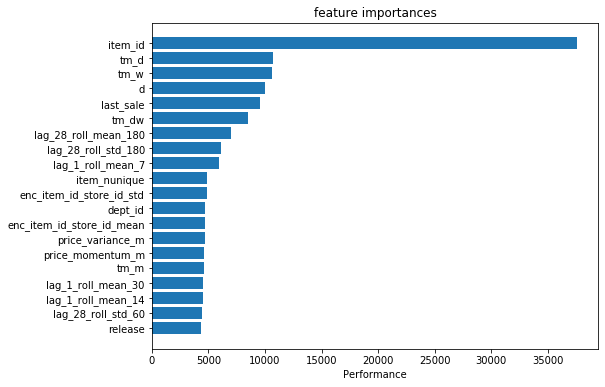

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
labels, values = [x[0] for x in feat_importances[:20]], [x[1] for x in feat_importances[:20]]
y_pos = np.arange(len(labels))
ax.barh(y_pos, values)
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.invert_yaxis()
ax.set_xlabel('Performance')
ax.set_title('feature importances')
plt.show()

In [19]:
%%time
spred = strain[
    (strain['d'] > (END_D - SHIFT_LCL - PRED_FWD)) &
    (strain['d'] <= (END_D - SHIFT_LCL)) &
    (strain['store_id'] == store_id)
].copy()
preds = []
for fold_num in range(N_FOLDS):
    model_file = '{}/model_{}_store_{}_fold_{}.lgb'.format(MODELS_DIR, MODEL_VER, store_id, fold_num)
    model = lgb.Booster(model_file=model_file)
    preds.append(model.predict(spred[train_cols]))
    print('done:', model_file)
preds = np.mean(preds, axis=0)
print(len(preds))
spred.loc[:, 'sales'] = np.where(preds <= .1, 0, preds)

done: C:/data/m5/models/model_v0_store_0_fold_0.lgb
done: C:/data/m5/models/model_v0_store_0_fold_1.lgb
done: C:/data/m5/models/model_v0_store_0_fold_2.lgb
done: C:/data/m5/models/model_v0_store_0_fold_3.lgb
85372
Wall time: 34.4 s


id to draw: HOUSEHOLD_1_179_CA_1_evaluation


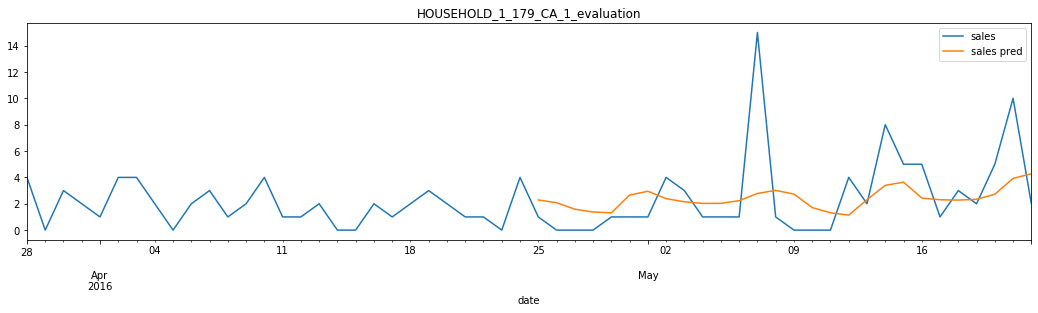

In [21]:
id_name = np.random.choice(strain[strain['store_id'] == store_id]['id'].unique())
print('id to draw:', id_name)
id_sales = strain.loc[
    (strain['id'] == id_name) & 
    (strain['d'] > (END_D - SHIFT_LCL - 2 * PRED_FWD)) &
    (strain['d'] <= (END_D - SHIFT_LCL)) &
    (strain['store_id'] == store_id)
].set_index('date')
id_sales_pred = spred.loc[spred['id'] == id_name].set_index('date')
plt.figure(figsize=(18, 4))
id_sales['sales'].plot(label='sales')
id_sales_pred['sales'].plot(label='sales pred')
plt.title(id_name)
plt.legend()
plt.show()

### PREDICT

In [13]:
for pred_d in tqdm(range(1, PRED_FWD + 1)):
    print('=' * 10, 'forecast day forward:', pred_d, '=' * 10) 
    strain = make_features_last_sales(strain)
    spred = strain[strain['d'] > (END_D - SHIFT_LCL - 100)].copy()
    spred = make_features_win(spred)
    for store_id in store_ids:
        preds = []
        for fold_num in range(N_FOLDS):
            model_file = '{}/model_{}_store_{}_fold_{}.lgb'.format(MODELS_DIR, MODEL_VER, store_id, fold_num)
            model = lgb.Booster(model_file=model_file)
            preds.append(
                model.predict(
                    spred.loc[
                        (spred['d'] == (END_D - SHIFT_LCL + pred_d)) & (spred['store_id'] == store_id), 
                        train_cols
                    ]
                )
            )
            print('store predicted:', store_id, '| model:', model_file)
        preds = np.mean(preds, axis=0)
        strain.loc[
            (strain['d'] == (END_D - SHIFT_LCL + pred_d)) & (strain['store_id'] == store_id), 
            'sales'
        ] = np.where(preds <= .1, 0, preds)
    all_sales = strain[strain['d'] == (END_D - SHIFT_LCL + pred_d)]['sales'].values
    print('day forward:', END_D - SHIFT_LCL + pred_d, 'all sales:', np.sum(all_sales))

========== forecast day forward: 1 ==========
---------- LAST SALES FEATURE ----------
in dataframe: (60034810, 105)
last non zero sales done
out dataframe: (60034810, 105)
time elapsed: 1 min 32 sec
---------- WIN ROLL FEATURES ----------
in dataframe: (4756440, 105)
window roll mean sales done
out dataframe: (4756440, 105)
time elapsed: 5 min 7 sec
store predicted: 0 | model: C:/data/m5/models/model_v0_store_0_fold_3.lgb
store predicted: 1 | model: C:/data/m5/models/model_v0_store_1_fold_3.lgb
store predicted: 2 | model: C:/data/m5/models/model_v0_store_2_fold_3.lgb
store predicted: 3 | model: C:/data/m5/models/model_v0_store_3_fold_3.lgb
store predicted: 4 | model: C:/data/m5/models/model_v0_store_4_fold_3.lgb
store predicted: 5 | model: C:/data/m5/models/model_v0_store_5_fold_3.lgb
store predicted: 6 | model: C:/data/m5/models/model_v0_store_6_fold_3.lgb
store predicted: 7 | model: C:/data/m5/models/model_v0_store_7_fold_3.lgb
store predicted: 8 | model: C:/data/m5/models/model_v0_

window roll mean sales done
out dataframe: (4756440, 105)
time elapsed: 5 min 1 sec
store predicted: 0 | model: C:/data/m5/models/model_v0_store_0_fold_3.lgb
store predicted: 1 | model: C:/data/m5/models/model_v0_store_1_fold_3.lgb
store predicted: 2 | model: C:/data/m5/models/model_v0_store_2_fold_3.lgb
store predicted: 3 | model: C:/data/m5/models/model_v0_store_3_fold_3.lgb
store predicted: 4 | model: C:/data/m5/models/model_v0_store_4_fold_3.lgb
store predicted: 5 | model: C:/data/m5/models/model_v0_store_5_fold_3.lgb
store predicted: 6 | model: C:/data/m5/models/model_v0_store_6_fold_3.lgb
store predicted: 7 | model: C:/data/m5/models/model_v0_store_7_fold_3.lgb
store predicted: 8 | model: C:/data/m5/models/model_v0_store_8_fold_3.lgb
store predicted: 9 | model: C:/data/m5/models/model_v0_store_9_fold_3.lgb
day forward: 1921 all sales: 45042.71104729787
========== forecast day forward: 9 ==========
---------- LAST SALES FEATURE ----------
in dataframe: (60034810, 105)
last non zer

store predicted: 2 | model: C:/data/m5/models/model_v0_store_2_fold_3.lgb
store predicted: 3 | model: C:/data/m5/models/model_v0_store_3_fold_3.lgb
store predicted: 4 | model: C:/data/m5/models/model_v0_store_4_fold_3.lgb
store predicted: 5 | model: C:/data/m5/models/model_v0_store_5_fold_3.lgb
store predicted: 6 | model: C:/data/m5/models/model_v0_store_6_fold_3.lgb
store predicted: 7 | model: C:/data/m5/models/model_v0_store_7_fold_3.lgb
store predicted: 8 | model: C:/data/m5/models/model_v0_store_8_fold_3.lgb
store predicted: 9 | model: C:/data/m5/models/model_v0_store_9_fold_3.lgb
day forward: 1928 all sales: 46346.608966732776
========== forecast day forward: 16 ==========
---------- LAST SALES FEATURE ----------
in dataframe: (60034810, 105)
last non zero sales done
out dataframe: (60034810, 105)
time elapsed: 1 min 40 sec
---------- WIN ROLL FEATURES ----------
in dataframe: (4756440, 105)
window roll mean sales done
out dataframe: (4756440, 105)
time elapsed: 5 min 3 sec
store 

store predicted: 5 | model: C:/data/m5/models/model_v0_store_5_fold_3.lgb
store predicted: 6 | model: C:/data/m5/models/model_v0_store_6_fold_3.lgb
store predicted: 7 | model: C:/data/m5/models/model_v0_store_7_fold_3.lgb
store predicted: 8 | model: C:/data/m5/models/model_v0_store_8_fold_3.lgb
store predicted: 9 | model: C:/data/m5/models/model_v0_store_9_fold_3.lgb
day forward: 1935 all sales: 43150.01705314148
========== forecast day forward: 23 ==========
---------- LAST SALES FEATURE ----------
in dataframe: (60034810, 105)
last non zero sales done
out dataframe: (60034810, 105)
time elapsed: 1 min 34 sec
---------- WIN ROLL FEATURES ----------
in dataframe: (4756440, 105)
window roll mean sales done
out dataframe: (4756440, 105)
time elapsed: 5 min 8 sec
store predicted: 0 | model: C:/data/m5/models/model_v0_store_0_fold_3.lgb
store predicted: 1 | model: C:/data/m5/models/model_v0_store_1_fold_3.lgb
store predicted: 2 | model: C:/data/m5/models/model_v0_store_2_fold_3.lgb
store p

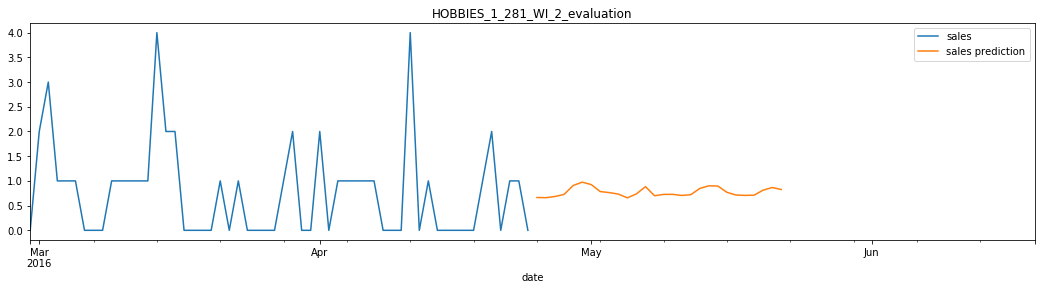

In [31]:
id_name = np.random.choice(strain['id'].unique())
id_sales = strain.loc[
    (strain['id'] == id_name) & 
    (strain['d'] > (END_D - SHIFT_LCL - 2 * PRED_FWD)) &
    (strain['d'] <= (END_D - SHIFT_LCL))
].set_index('date')
id_sales_pred = strain.loc[
    (strain['id'] == id_name) & 
    (strain['d'] > (END_D - SHIFT_LCL))
].set_index('date')
plt.figure(figsize=(18, 4))
id_sales['sales'].plot(label='sales')
id_sales_pred['sales'].plot(label='sales prediction')
plt.title(id_name)
plt.legend()
plt.show()

In [32]:
spred_subm = strain.loc[strain['d'] > (END_D - SHIFT_LCL), ['id', 'd', 'sales']].copy()
spred_subm['d'] = spred_subm['d'].apply(lambda x: 'F{}'.format(x - (END_D - SHIFT_LCL)))
spred_subm.loc[spred_subm['sales'] < 0, 'sales'] = 0

In [33]:
f_cols = ['F{}'.format(x) for x in range(1, PRED_FWD + 1)]
spred_subm = spred_subm.set_index(['id', 'd']).unstack()['sales'][f_cols].reset_index()
spred_subm.fillna(0, inplace=True)
spred_subm.sort_values('id', inplace=True)
spred_subm.reset_index(drop=True, inplace=True)
spred_subm.head()

d,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,0.810057,0.731086,0.714523,0.729439,0.950816,1.084655,1.038717,0.854123,0.835062,0.824844,0.759795,1.029482,1.080815,0.883844,0.873782,0.759529,0.774110,0.763175,0.917360,1.025287,0.976959,0.794280,0.714563,0.710225,0.704443,0.820788,0.972627,0.892406
1,FOODS_1_001_CA_2_evaluation,1.044732,1.098167,1.055442,1.036331,1.126226,1.597871,1.792520,1.148494,1.230853,1.091420,1.159455,1.188468,1.539800,1.258620,1.016680,1.040626,1.105732,1.054769,1.194987,1.426491,1.495362,1.061870,1.141526,1.054840,1.085424,1.163184,1.479113,1.486342
2,FOODS_1_001_CA_3_evaluation,0.993594,1.132829,1.117257,1.076007,1.254729,1.662002,1.733423,1.018552,1.001789,0.969673,1.018739,1.118443,1.464854,1.363625,0.922825,0.907853,0.939900,0.910440,1.103762,1.452717,1.618640,0.995569,0.995992,1.038792,1.029782,1.165060,1.508247,1.622916
3,FOODS_1_001_CA_4_evaluation,0.365212,0.338362,0.299897,0.307283,0.323562,0.377348,0.375457,0.378177,0.363229,0.349737,0.348267,0.379150,0.404024,0.348543,0.406130,0.390479,0.387785,0.388805,0.367136,0.412126,0.399278,0.394533,0.360476,0.354334,0.338448,0.336531,0.384392,0.396093
4,FOODS_1_001_TX_1_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [34]:
spred_subm_val = spred_subm.copy()
spred_subm_val['id'] = spred_subm_eval['id'].str.replace('evaluation', 'validation')
spred_subm = pd.concat([spred_subm_val, spred_subm], axis=0, sort=False)
spred_subm.reset_index(drop=True, inplace=True)
spred_subm.to_csv('{}/submission.csv'.format(DATA_DIR), index=False)
print('submission saved:', spred_subm.shape)

submission saved: (60980, 29)


### EVALUATE

In [19]:
class WRMSSEEvaluator(object):
    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, calendar: pd.DataFrame, prices: pd.DataFrame):
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        weight_columns = train_y.iloc[:, -28:].columns.tolist()
        train_df['all_id'] = 0  # for lv1 aggregation
        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')].columns.tolist()
        valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')].columns.tolist()
        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], axis=1, sort=False)
        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices
        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns
        weight_df = self.get_weight_df()
        self.group_ids = (
            'all_id',
            'cat_id',
            'state_id',
            'dept_id',
            'store_id',
            'item_id',
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
        )
        for i, group_id in enumerate(tqdm(self.group_ids)):
            train_y = train_df.groupby(group_id)[train_target_columns].sum()
            scale = []
            for _, row in train_y.iterrows():
                series = row.values[np.argmax(row.values != 0):]
                scale.append(((series[1:] - series[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_scale', np.array(scale))
            setattr(self, f'lv{i + 1}_train_df', train_y)
            setattr(self, f'lv{i + 1}_valid_df', valid_df.groupby(group_id)[valid_target_columns].sum())
            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())
    def get_weight_df(self) -> pd.DataFrame:
        day_to_week = self.calendar.set_index('d')['wm_yr_wk'].to_dict()
        weight_df = self.train_df[['item_id', 'store_id'] + self.weight_columns].set_index(['item_id', 'store_id'])
        weight_df = weight_df.stack().reset_index().rename(columns={'level_2': 'd', 0: 'value'})
        weight_df['wm_yr_wk'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left', on=['item_id', 'store_id', 'wm_yr_wk'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        weight_df = weight_df.set_index(['item_id', 'store_id', 'd']).unstack(level=2)['value']
        weight_df = weight_df.loc[zip(self.train_df.item_id, self.train_df.store_id), :].reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns], weight_df], axis=1, sort=False)
        return weight_df
    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = getattr(self, f'lv{lv}_scale')
        return (score / scale).map(np.sqrt)
    def score(self, valid_preds: Union[pd.DataFrame, np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape
        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)
        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds], axis=1, sort=False)
        group_ids = []
        all_scores = []
        for i, group_id in enumerate(self.group_ids):
            lv_scores = self.rmsse(valid_preds.groupby(group_id)[self.valid_target_columns].sum(), i + 1)
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, sort=False).prod(axis=1)
            group_ids.append(group_id)
            all_scores.append(lv_scores.sum())
        return group_ids, all_scores

In [20]:
df_train_full = pd.read_csv('{}/sales_train_evaluation.csv'.format(DATA_DIR))
df_calendar = pd.read_csv("{}/calendar.csv".format(DATA_DIR))
df_prices = pd.read_csv("{}/sell_prices.csv".format(DATA_DIR))
df_sample_submission = pd.read_csv("{}/sample_submission.csv".format(DATA_DIR))
df_sample_submission["order"] = range(df_sample_submission.shape[0])
df_train = df_train_full.iloc[:, :-28]
df_valid = df_train_full.iloc[:, -28:]
evaluator = WRMSSEEvaluator(df_train, df_valid, df_calendar, df_prices)

In [44]:
preds_valid = pd.read_csv("{}/submission.csv".format(DATA_DIR))
preds_valid = preds_valid[preds_valid.id.str.contains("validation")]
preds_valid = preds_valid.merge(
    df_sample_submission[["id", "order"]], 
    on="id"
).sort_values("order").drop(
    ["id", "order"], 
    axis=1
)
columns = {}
for i in range(PRED_FWD):
    columns['F{}'.format(i + 1)] = 'd_{}'.format(END_D - PRED_FWD + i + 1)
print(columns)
preds_valid.rename(columns=columns, inplace=True)
preds_valid.reset_index(inplace=True, drop=True)

In [46]:
groups, scores = evaluator.score(preds_valid)
score_public_lb = np.mean(scores)
for i in range(len(groups)):
    print(f"Score for group {groups[i]}: {round(scores[i], 5)}")
print(f"\nPublic LB Score: {round(score_public_lb, 5)}")

Score for group all_id: 0.23213
Score for group cat_id: 0.27076
Score for group state_id: 0.27742
Score for group dept_id: 0.32764
Score for group store_id: 0.31373
Score for group item_id: 0.77137
Score for group ['state_id', 'cat_id']: 0.33393
Score for group ['state_id', 'dept_id']: 0.39865
Score for group ['store_id', 'cat_id']: 0.38668
Score for group ['store_id', 'dept_id']: 0.47116
Score for group ['item_id', 'state_id']: 0.78836
Score for group ['item_id', 'store_id']: 0.79667

Public LB Score: 0.44737
